In [43]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [46]:
DATA_DIR = "/kaggle/input/datasets/kabil007/lungcancer4types-imagedataset/Data"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "valid")
TEST_DIR  = os.path.join(DATA_DIR, "test")


In [47]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
  
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [48]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

NUM_CLASSES = len(train_ds.classes)
print("Classes:", train_ds.classes)


Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


In [59]:
print(train_ds)

Dataset ImageFolder
    Number of datapoints: 613
    Root location: /kaggle/input/datasets/kabil007/lungcancer4types-imagedataset/Data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [49]:
MSCViT_CONFIGS = {
    "MSCViT-T": {
        "stem_channels": 16,
        "stages": [
            {"C": 32,  "P": 3, "R": 4},
            {"C": 64,  "P": 3, "R": 3},
            {"C": 128, "P": 5, "R": 2},
            {"C": 256, "P": 5, "R": 1},
        ],
    },
    "MSCViT-XS": {
        "stem_channels": 24,
        "stages": [
            {"C": 48,  "P": 3, "R": 4},
            {"C": 96,  "P": 3, "R": 3},
            {"C": 192, "P": 5, "R": 2},
            {"C": 384, "P": 5, "R": 1},
        ],
    },
    "MSCViT-S": {
        "stem_channels": 32,
        "stages": [
            {"C": 64,  "P": 3, "R": 4},
            {"C": 128, "P": 3, "R": 3},
            {"C": 256, "P": 5, "R": 2},
            {"C": 512, "P": 5, "R": 1},
        ],
    },
}
import torch
import torch.nn as nn

class ConvStem(nn.Module):
    def __init__(self, out_channels):
        super().__init__()
        self.stem = nn.Sequential(
            # First conv: downsample
            nn.Conv2d(3, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # Repeat conv (×2) with stride = 1
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.stem(x)

class DWConv(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dw = nn.Conv2d(dim, dim, 3, padding=1, groups=dim, bias=False)
        self.pw = nn.Conv2d(dim, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.pw(self.dw(x))))

class LFE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = DWConv(dim)

    def forward(self, x):
        return self.conv(x)

class ChannelMixer(nn.Module):
    def __init__(self, dim, expansion=2):
        super().__init__()
        hidden = dim * expansion
        self.fc1 = nn.Conv2d(dim, hidden, 1, bias=False)
        self.act = nn.GELU()
        self.fc2 = nn.Conv2d(hidden, dim, 1, bias=False)
        self.bn = nn.BatchNorm2d(dim)

    def forward(self, x):
        return self.bn(self.fc2(self.act(self.fc1(x))))

class MSCBlock(nn.Module):
    def __init__(self, dim, attn_depth):
        super().__init__()

        self.lfe = LFE(dim)

        self.mixers = nn.ModuleList([
            ChannelMixer(dim)
            for _ in range(attn_depth)
        ])

    def forward(self, x):
        x = x + self.lfe(x)
        for m in self.mixers:
            x = x + m(x)
        return x

class Stage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, attn_depth):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.blocks = nn.ModuleList([
            MSCBlock(out_channels, attn_depth)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        x = self.downsample(x)
        for blk in self.blocks:
            x = blk(x)
        return x
class MSCViT(nn.Module):
    def __init__(self, variant="MSCViT-T", num_classes=1000, global_pool="avg"):
        super().__init__()

        cfg = MSCViT_CONFIGS[variant]
        self.__class__.__name__ = variant

        self.stem = ConvStem(cfg["stem_channels"])

        in_ch = cfg["stem_channels"]
        self.stages = nn.ModuleList()

        for s in cfg["stages"]:
            self.stages.append(
                Stage(in_ch, s["C"], s["P"], s["R"])
            )
            in_ch = s["C"]

        self.head = nn.Linear(in_ch, num_classes) if num_classes > 0 else nn.Identity()
        self.global_pool = global_pool

    def forward(self, x):
        x = self.stem(x)
        for stage in self.stages:
            x = stage(x)

        x = x.mean((2, 3)) if self.global_pool == "avg" else x.amax((2, 3))
        return self.head(x)
from torchinfo import summary
import torch

image_size = 224           # Standard starting resolution
patch_size = 16            # Balanced for detail vs. compute
in_channels = 3            # Colored images
num_classes = 6            # Four-class classification task

# Medical imaging / Kaggle dataset
model = MSCViT("MSCViT-T", num_classes=4)
model.to(device)

summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params"),
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
MSCViT-T                                                [1, 3, 224, 224]          [1, 4]                    --
├─ConvStem: 1-1                                         [1, 3, 224, 224]          [1, 16, 112, 112]         --
│    └─Sequential: 2-1                                  [1, 3, 224, 224]          [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                            [1, 16, 112, 112]         [1, 16, 112, 112]         32
│    │    └─ReLU: 3-3                                   [1, 16, 112, 112]         [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-4                                 [1, 16, 112, 112]         [1, 16, 112, 112]         2,304
│    │    └─BatchNorm2d: 3-5                            [1, 16, 112, 112]         [1, 16, 112, 112]    

In [50]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    num_classes=4
  # Replace the tn/fp/fn/tp block with:
    specificities = []
    sensitivities = []
    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp
        specificities.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        sensitivities.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
    specificity = np.mean(specificities)
    sensitivity = np.mean(sensitivities)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [51]:
# Hyperparameters
num_epochs       = 25
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [52]:
num_classes=4

In [53]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    # Validation loop
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    # Step the scheduler to decay the learning rate by 0.995
    scheduler.step()

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 39/39 [00:02<00:00, 14.08it/s]


Metrics - loss: 1.1126, accuracy: 0.5726, precision: 0.5777, recall: 0.5726, f1_score: 0.5728, specificity: 0.8570, sensitivity: 0.5752, mcc: 0.4291, auc: 0.7403


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.15it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics - loss: 3.0400, accuracy: 0.2083, precision: 0.0446, recall: 0.2083, f1_score: 0.0735, specificity: 0.7486, sensitivity: 0.2500, mcc: -0.0155, auc: 0.6226


Training Model - Epoch [2/25]: 100%|██████████| 39/39 [00:02<00:00, 14.13it/s]


Metrics - loss: 0.7081, accuracy: 0.6803, precision: 0.6750, recall: 0.6803, f1_score: 0.6738, specificity: 0.8904, sensitivity: 0.6604, mcc: 0.5669, auc: 0.8300


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.40it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics - loss: 0.9776, accuracy: 0.5556, precision: 0.4147, recall: 0.5556, f1_score: 0.4645, specificity: 0.8439, sensitivity: 0.5783, mcc: 0.4445, auc: 0.7734


Training Model - Epoch [3/25]: 100%|██████████| 39/39 [00:02<00:00, 15.26it/s]


Metrics - loss: 0.5805, accuracy: 0.8075, precision: 0.8040, recall: 0.8075, f1_score: 0.8049, specificity: 0.9348, sensitivity: 0.7943, mcc: 0.7399, auc: 0.9074


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]


Metrics - loss: 0.9852, accuracy: 0.6389, precision: 0.7039, recall: 0.6389, f1_score: 0.6411, specificity: 0.8802, sensitivity: 0.6798, mcc: 0.5421, auc: 0.8105


Training Model - Epoch [4/25]: 100%|██████████| 39/39 [00:02<00:00, 15.10it/s]


Metrics - loss: 0.3280, accuracy: 0.8940, precision: 0.8937, recall: 0.8940, f1_score: 0.8934, specificity: 0.9644, sensitivity: 0.8860, mcc: 0.8571, auc: 0.9527


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.33it/s]


Metrics - loss: 1.6980, accuracy: 0.4722, precision: 0.6894, recall: 0.4722, f1_score: 0.4395, specificity: 0.8314, sensitivity: 0.5526, mcc: 0.4244, auc: 0.7734


Training Model - Epoch [5/25]: 100%|██████████| 39/39 [00:02<00:00, 14.79it/s]


Metrics - loss: 0.2680, accuracy: 0.9152, precision: 0.9147, recall: 0.9152, f1_score: 0.9149, specificity: 0.9715, sensitivity: 0.9105, mcc: 0.8855, auc: 0.9678


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.46it/s]


Metrics - loss: 1.3437, accuracy: 0.6389, precision: 0.7124, recall: 0.6389, f1_score: 0.6454, specificity: 0.8799, sensitivity: 0.6702, mcc: 0.5363, auc: 0.7813


Training Model - Epoch [6/25]: 100%|██████████| 39/39 [00:02<00:00, 15.57it/s]


Metrics - loss: 0.1714, accuracy: 0.9462, precision: 0.9462, recall: 0.9462, f1_score: 0.9459, specificity: 0.9817, sensitivity: 0.9410, mcc: 0.9274, auc: 0.9784


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.48it/s]


Metrics - loss: 1.1701, accuracy: 0.5972, precision: 0.6440, recall: 0.5972, f1_score: 0.5920, specificity: 0.8584, sensitivity: 0.6130, mcc: 0.4656, auc: 0.8109


Training Model - Epoch [7/25]: 100%|██████████| 39/39 [00:02<00:00, 14.57it/s]


Metrics - loss: 0.1175, accuracy: 0.9706, precision: 0.9708, recall: 0.9706, f1_score: 0.9707, specificity: 0.9902, sensitivity: 0.9698, mcc: 0.9604, auc: 0.9904


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Metrics - loss: 1.4702, accuracy: 0.5556, precision: 0.7177, recall: 0.5556, f1_score: 0.5325, specificity: 0.8511, sensitivity: 0.6037, mcc: 0.4493, auc: 0.8187


Training Model - Epoch [8/25]: 100%|██████████| 39/39 [00:02<00:00, 14.63it/s]


Metrics - loss: 0.1575, accuracy: 0.9511, precision: 0.9514, recall: 0.9511, f1_score: 0.9510, specificity: 0.9837, sensitivity: 0.9528, mcc: 0.9343, auc: 0.9911


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.44it/s]


Metrics - loss: 1.5242, accuracy: 0.6250, precision: 0.6845, recall: 0.6250, f1_score: 0.6209, specificity: 0.8756, sensitivity: 0.6737, mcc: 0.5296, auc: 0.8084


Training Model - Epoch [9/25]: 100%|██████████| 39/39 [00:02<00:00, 15.00it/s]


Metrics - loss: 0.1526, accuracy: 0.9527, precision: 0.9530, recall: 0.9527, f1_score: 0.9526, specificity: 0.9839, sensitivity: 0.9516, mcc: 0.9363, auc: 0.9893


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]


Metrics - loss: 1.4492, accuracy: 0.6389, precision: 0.6750, recall: 0.6389, f1_score: 0.6471, specificity: 0.8712, sensitivity: 0.6555, mcc: 0.5119, auc: 0.8127


Training Model - Epoch [10/25]: 100%|██████████| 39/39 [00:02<00:00, 14.25it/s]


Metrics - loss: 0.0907, accuracy: 0.9706, precision: 0.9708, recall: 0.9706, f1_score: 0.9706, specificity: 0.9901, sensitivity: 0.9702, mcc: 0.9604, auc: 0.9939


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


Metrics - loss: 1.4191, accuracy: 0.6389, precision: 0.6557, recall: 0.6389, f1_score: 0.6394, specificity: 0.8748, sensitivity: 0.6745, mcc: 0.5167, auc: 0.8205


Training Model - Epoch [11/25]: 100%|██████████| 39/39 [00:02<00:00, 15.18it/s]


Metrics - loss: 0.0422, accuracy: 0.9886, precision: 0.9886, recall: 0.9886, f1_score: 0.9886, specificity: 0.9961, sensitivity: 0.9877, mcc: 0.9846, auc: 0.9977


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.47it/s]


Metrics - loss: 1.3577, accuracy: 0.6389, precision: 0.7159, recall: 0.6389, f1_score: 0.6402, specificity: 0.8776, sensitivity: 0.6666, mcc: 0.5316, auc: 0.8457


Training Model - Epoch [12/25]: 100%|██████████| 39/39 [00:02<00:00, 14.89it/s]


Metrics - loss: 0.0672, accuracy: 0.9739, precision: 0.9739, recall: 0.9739, f1_score: 0.9739, specificity: 0.9913, sensitivity: 0.9725, mcc: 0.9648, auc: 0.9966


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.73it/s]


Metrics - loss: 1.2085, accuracy: 0.6389, precision: 0.6607, recall: 0.6389, f1_score: 0.6427, specificity: 0.8766, sensitivity: 0.6671, mcc: 0.5182, auc: 0.8342


Training Model - Epoch [13/25]: 100%|██████████| 39/39 [00:02<00:00, 14.77it/s]


Metrics - loss: 0.0803, accuracy: 0.9706, precision: 0.9706, recall: 0.9706, f1_score: 0.9706, specificity: 0.9901, sensitivity: 0.9685, mcc: 0.9604, auc: 0.9948


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


Metrics - loss: 1.7124, accuracy: 0.6389, precision: 0.6681, recall: 0.6389, f1_score: 0.6376, specificity: 0.8753, sensitivity: 0.6709, mcc: 0.5211, auc: 0.8051


Training Model - Epoch [14/25]: 100%|██████████| 39/39 [00:02<00:00, 14.94it/s]


Metrics - loss: 0.0684, accuracy: 0.9853, precision: 0.9854, recall: 0.9853, f1_score: 0.9853, specificity: 0.9951, sensitivity: 0.9871, mcc: 0.9802, auc: 0.9971


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Metrics - loss: 2.2148, accuracy: 0.4306, precision: 0.5045, recall: 0.4306, f1_score: 0.3860, specificity: 0.8152, sensitivity: 0.5132, mcc: 0.3316, auc: 0.8094


Training Model - Epoch [15/25]: 100%|██████████| 39/39 [00:02<00:00, 14.67it/s]


Metrics - loss: 0.0497, accuracy: 0.9837, precision: 0.9837, recall: 0.9837, f1_score: 0.9837, specificity: 0.9943, sensitivity: 0.9828, mcc: 0.9780, auc: 0.9976


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.36it/s]


Metrics - loss: 1.6174, accuracy: 0.6528, precision: 0.6878, recall: 0.6528, f1_score: 0.6516, specificity: 0.8811, sensitivity: 0.6734, mcc: 0.5414, auc: 0.8271


Training Model - Epoch [16/25]: 100%|██████████| 39/39 [00:02<00:00, 15.02it/s]


Metrics - loss: 0.0655, accuracy: 0.9804, precision: 0.9806, recall: 0.9804, f1_score: 0.9804, specificity: 0.9934, sensitivity: 0.9791, mcc: 0.9737, auc: 0.9966


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.71it/s]


Metrics - loss: 1.4411, accuracy: 0.6111, precision: 0.6566, recall: 0.6111, f1_score: 0.6108, specificity: 0.8642, sensitivity: 0.6307, mcc: 0.4826, auc: 0.8488


Training Model - Epoch [17/25]: 100%|██████████| 39/39 [00:02<00:00, 14.44it/s]


Metrics - loss: 0.0842, accuracy: 0.9788, precision: 0.9791, recall: 0.9788, f1_score: 0.9787, specificity: 0.9928, sensitivity: 0.9758, mcc: 0.9715, auc: 0.9952


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


Metrics - loss: 1.6143, accuracy: 0.6250, precision: 0.6667, recall: 0.6250, f1_score: 0.6327, specificity: 0.8731, sensitivity: 0.6573, mcc: 0.5067, auc: 0.8237


Training Model - Epoch [18/25]: 100%|██████████| 39/39 [00:02<00:00, 14.91it/s]


Metrics - loss: 0.0798, accuracy: 0.9902, precision: 0.9903, recall: 0.9902, f1_score: 0.9902, specificity: 0.9968, sensitivity: 0.9892, mcc: 0.9868, auc: 0.9957


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.77it/s]


Metrics - loss: 1.9366, accuracy: 0.5833, precision: 0.7303, recall: 0.5833, f1_score: 0.5620, specificity: 0.8591, sensitivity: 0.6164, mcc: 0.4730, auc: 0.8154


Training Model - Epoch [19/25]: 100%|██████████| 39/39 [00:02<00:00, 15.33it/s]


Metrics - loss: 0.0709, accuracy: 0.9853, precision: 0.9853, recall: 0.9853, f1_score: 0.9853, specificity: 0.9951, sensitivity: 0.9839, mcc: 0.9802, auc: 0.9980


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


Metrics - loss: 2.0842, accuracy: 0.5972, precision: 0.7272, recall: 0.5972, f1_score: 0.6024, specificity: 0.8687, sensitivity: 0.6498, mcc: 0.5179, auc: 0.8095


Training Model - Epoch [20/25]: 100%|██████████| 39/39 [00:02<00:00, 14.09it/s]


Metrics - loss: 0.0744, accuracy: 0.9674, precision: 0.9674, recall: 0.9674, f1_score: 0.9673, specificity: 0.9891, sensitivity: 0.9666, mcc: 0.9561, auc: 0.9971


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.74it/s]


Metrics - loss: 1.4661, accuracy: 0.6250, precision: 0.7351, recall: 0.6250, f1_score: 0.6316, specificity: 0.8777, sensitivity: 0.6726, mcc: 0.5466, auc: 0.8455


Training Model - Epoch [21/25]: 100%|██████████| 39/39 [00:02<00:00, 14.94it/s]


Metrics - loss: 0.0374, accuracy: 0.9918, precision: 0.9919, recall: 0.9918, f1_score: 0.9918, specificity: 0.9973, sensitivity: 0.9911, mcc: 0.9890, auc: 0.9985


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.03it/s]


Metrics - loss: 1.5136, accuracy: 0.6528, precision: 0.6915, recall: 0.6528, f1_score: 0.6571, specificity: 0.8809, sensitivity: 0.6838, mcc: 0.5408, auc: 0.8137


Training Model - Epoch [22/25]: 100%|██████████| 39/39 [00:02<00:00, 14.74it/s]


Metrics - loss: 0.0354, accuracy: 0.9902, precision: 0.9902, recall: 0.9902, f1_score: 0.9902, specificity: 0.9967, sensitivity: 0.9903, mcc: 0.9868, auc: 0.9983


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.75it/s]


Metrics - loss: 1.6929, accuracy: 0.5694, precision: 0.6971, recall: 0.5694, f1_score: 0.5713, specificity: 0.8594, sensitivity: 0.6177, mcc: 0.4814, auc: 0.8209


Training Model - Epoch [23/25]: 100%|██████████| 39/39 [00:02<00:00, 14.54it/s]


Metrics - loss: 0.0108, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 0.9995, sensitivity: 0.9987, mcc: 0.9978, auc: 0.9996


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.21it/s]


Metrics - loss: 1.7096, accuracy: 0.6111, precision: 0.7016, recall: 0.6111, f1_score: 0.6082, specificity: 0.8667, sensitivity: 0.6329, mcc: 0.4946, auc: 0.8182


Training Model - Epoch [24/25]: 100%|██████████| 39/39 [00:02<00:00, 14.55it/s]


Metrics - loss: 0.0381, accuracy: 0.9951, precision: 0.9951, recall: 0.9951, f1_score: 0.9951, specificity: 0.9984, sensitivity: 0.9946, mcc: 0.9934, auc: 0.9978


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 13.07it/s]


Metrics - loss: 1.5877, accuracy: 0.6250, precision: 0.6995, recall: 0.6250, f1_score: 0.6311, specificity: 0.8741, sensitivity: 0.6585, mcc: 0.5190, auc: 0.8282


Training Model - Epoch [25/25]: 100%|██████████| 39/39 [00:02<00:00, 15.03it/s]


Metrics - loss: 0.0170, accuracy: 0.9984, precision: 0.9984, recall: 0.9984, f1_score: 0.9984, specificity: 0.9995, sensitivity: 0.9978, mcc: 0.9978, auc: 0.9983


Validating Model: 100%|██████████| 5/5 [00:00<00:00, 12.72it/s]

Metrics - loss: 1.8215, accuracy: 0.6111, precision: 0.6915, recall: 0.6111, f1_score: 0.6147, specificity: 0.8704, sensitivity: 0.6549, mcc: 0.5088, auc: 0.8187
Total Training Time: 0:01:06.129545
Total Validation Time: 0:00:09.619172
Average Training Time per Epoch: 0:00:02.645182
Average Validation Time per Epoch: 0:00:00.384767


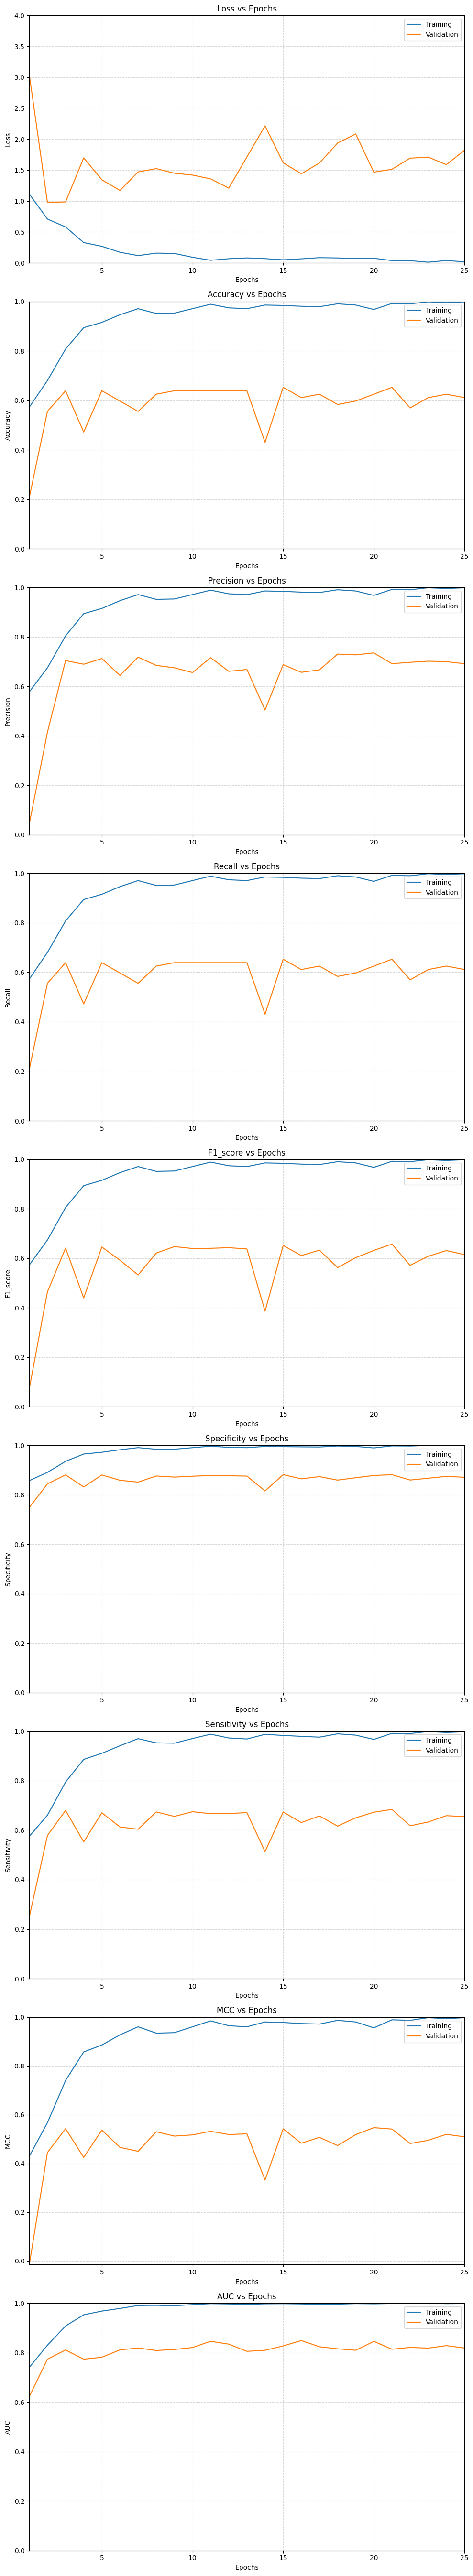

In [54]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [55]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 20/20 [00:01<00:00, 14.07it/s]

Metrics - loss: 2.9540, accuracy: 0.4413, precision: 0.4420, recall: 0.4413, f1_score: 0.3931, specificity: 0.8179, sensitivity: 0.5539, mcc: 0.3148, auc: 0.7494


In [56]:
classes= ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
